In [1]:
import json
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import tifffile
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import RandomHorizontalFlip, RandomVerticalFlip, Normalize, RandomCrop, Compose
from einops import rearrange
from kmeans_pytorch import kmeans

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import multiplex_imaging_pipeline.utils as utils
from vit_pytorch import ViT, MAE
from vit_pytorch.slide_mae import SlideMAE, SlideMAEV2


In [5]:
metadata = json.load(open('../data/test_registration/HT397B1_v2/registered/metadata.json'))
metadata

{'downsample_scaler': 0.1,
 'phenocycler_pixels_per_micron': 1.9604911906033102,
 'order': ['HT397B1-S1H3A1U1',
  'HT397B1-S1H3A1U2',
  'HT397B1-S1H3A1U12',
  'HT397B1-S1H3A1U21',
  'HT397B1-S1H3A1U22',
  'HT397B1-S1H3A1U31'],
 'data_type': ['visium', 'codex', 'codex', 'visium', 'codex', 'codex'],
 'slices': ['s0', 's1', 's2', 's3', 's4', 's5']}

In [6]:
fps = sorted(utils.listfiles('/data/estorrs/mushroom/data/test_registration/HT397B1_v2/registered',
                     regex='[0-9].h5ad$'))
fps

['/data/estorrs/mushroom/data/test_registration/HT397B1_v2/registered/s0.h5ad',
 '/data/estorrs/mushroom/data/test_registration/HT397B1_v2/registered/s3.h5ad']

In [7]:
pct_expression = .02
pool = []
for fp in fps:
    a = sc.read_h5ad(fp)
    
    spot_count = (a.X.toarray()>0).sum(0)
    mask = spot_count > pct_expression * a.shape[0]
    a = a[:, mask]

    pool += a.var.index.to_list()
counts = Counter(pool)
channels = sorted([c for c, count in counts.items() if count==len(fps)])
len(channels), channels[:5]

(11630, ['A1BG', 'A2M', 'A4GALT', 'AAAS', 'AACS'])

In [8]:
scale = .1

In [9]:
slide_to_adata = {}
for fp in fps:
    sample = fp.split('/')[-1].replace('.h5ad', '')
    a = sc.read_h5ad(fp)
    label_to_barcode = {i+1:x for i, x in enumerate(a.obs.index)}
    barcode_to_label = {v:k for k, v in label_to_barcode.items()}
    a.uns['label_to_barcode'] = label_to_barcode
    a.uns['barcode_to_label'] = barcode_to_label
    a.obsm['spatial_scaled'] = (a.obsm['spatial'] * scale).astype(np.int32)
    
    a = a[:, channels]
    sc.pp.log1p(a)
    
    slide_to_adata[sample] = a
slide_to_adata.keys()

/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:373: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:373: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


dict_keys(['s0', 's3'])

In [10]:
a = next(iter(slide_to_adata.values()))
a

AnnData object with n_obs × n_vars = 3058 × 11630
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'he_rescaled', 'he_rescaled_warped', 'spatial', 'label_to_barcode', 'barcode_to_label', 'log1p'
    obsm: 'he_rescaled_spatial', 'spatial', 'spatial_original', 'spatial_scaled'

In [11]:
def format_expression(tile, adata, patch_size):
    tile = rearrange(tile, '(ph h) (pw w) -> h w (ph pw)', ph=patch_size, pw=patch_size)
    x = torch.unique(tile, dim=-1)

    to_return = torch.zeros(x.shape[0], x.shape[1], adata.shape[1], dtype=torch.float32)
    l2b = adata.uns['label_to_barcode']
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            labels = x[i, j]
            labels = labels[labels!=0]
            if len(labels):
                barcodes = [l2b[l.item()] for l in labels]
                to_return[i, j] = torch.tensor(adata[barcodes].X.mean(0))
    return rearrange(to_return, 'h w c -> c h w')

def get_slide_to_labeled(slide_to_adata, crop=True, scale=.1):
    slide_to_labeled = {}
    for s, a in slide_to_adata.items():
        labeled_locations = np.zeros(
            (np.asarray(a.uns['he_rescaled_warped'].shape[:2]) * scale).astype(int), dtype=int)
        for barcode, (c, r) in zip(a.obs.index, a.obsm['spatial_scaled']):
            labeled_locations[r, c] = a.uns['barcode_to_label'][barcode]

        if crop:
            min_c, min_r = a.obsm['spatial_scaled'].min(0)
            max_c, max_r = a.obsm['spatial_scaled'].max(0)
        else:
            min_r, min_c = 0, 0
            max_r, max_c = labeled_locations.shape
        labeled_locations = labeled_locations[min_r:max_r, min_c:max_c]
        slide_to_labeled[s] = torch.tensor(labeled_locations)
    return slide_to_labeled

class MAETransformVisium(object):
    def __init__(self, size=(256, 256), patch_size=32, normalize=None):
        self.size = size
        self.patch_size = patch_size
        self.transforms = Compose([
            RandomCrop(size, padding_mode='reflect'),
            RandomHorizontalFlip(),
            RandomVerticalFlip(),
        ])

        self.normalize = normalize if normalize is not None else nn.Identity()

    def __call__(self, x, adata):
        tile = self.transforms(x).squeeze()
        tile = format_expression(tile, adata, patch_size=self.patch_size)
        tile = self.normalize(tile)
        return tile
        
    
class InferenceTransformVisium(object):
    def __init__(self, size=(256, 256), patch_size=32, normalize=None):
        self.size = size
        self.patch_size = patch_size
        self.normalize = normalize if normalize is not None else nn.Identity()

    def __call__(self, x, adata):
        tile = x.squeeze()
        tile = format_expression(tile, adata, patch_size=self.patch_size)
        tile = self.normalize(tile)
        return tile

    
class SlideDatasetVisium(Dataset):
    def __init__(self, slide_to_adata, transform=None, scale=.1, crop=True):
        self.scale = scale
        self.slides = sorted(slide_to_adata.keys())
        self.slide_to_adata = slide_to_adata
        
        self.slide_to_labeled = get_slide_to_labeled(slide_to_adata, crop=crop, scale=scale)
        
        self.transform = transform if transform is not None else nn.Identity()

    def __len__(self):
        return np.iinfo(np.int64).max # make infinite

    def __getitem__(self, idx):
        slide = np.random.choice(self.slides)
        idx = self.slides.index(slide)
        a = slide_to_adata[slide]
        return {
            'slide_idx': idx,
            'img': transform(self.slide_to_labeled[slide].unsqueeze(0), a)
        }
    
    
class InferenceSlideDatasetVisium(Dataset):
    def __init__(self, slide_to_img, size=(256, 256), transform=None, crop=False, scale=.1):
        """"""
        self.size = size
        self.scale = scale
        self.slides = sorted(slide_to_adata.keys())
        self.slide_to_adata = slide_to_adata
        
        self.slide_to_labeled = get_slide_to_labeled(slide_to_adata, crop=crop, scale=scale)
        
        # tiles are (ph pw c h w)
        self.slide_to_tiles = {s:self.to_tiles(x.unsqueeze(0)) for s, x in self.slide_to_labeled.items()}
        self.pw, self.ph = self.slide_to_tiles[self.slides[0]].shape[:2]
        
        self.n_tiles_per_image = self.pw * self.ph
        outs = torch.stack(torch.meshgrid(
            torch.arange(len(self.slides)),
            torch.arange(self.slide_to_tiles[self.slides[0]].shape[0]),
            torch.arange(self.slide_to_tiles[self.slides[0]].shape[1])
        ))
        self.idx_to_coord = rearrange(
            outs, 'b n_slides n_rows n_cols -> (n_slides n_rows n_cols) b',
            n_slides=len(self.slides), n_rows=self.ph, n_cols=self.pw, b=3)


        self.transform = transform if transform is not None else nn.Identity()
        
    def to_tiles(self, x):
        pad_h, pad_w = self.size[-2] - x.shape[-2] % self.size[-2], self.size[-1] - x.shape[-1] % self.size[-1]
        # left, top, right and bottom
        x = TF.pad(x, [pad_w // 2, pad_h // 2, pad_w // 2 + pad_w % 2, pad_h // 2 + pad_h % 2])
        x = x.unfold(-2, self.size[-2], self.size[-2] // 2)
        x = x.unfold(-2, self.size[-1], self.size[-1] // 2)
        x = rearrange(x, 'c ph pw h w -> ph pw c h w')
        return x

    def image_from_tiles(self, x, to_expression=False, adata=None):
        pad_h, pad_w = x.shape[-2] // 4, x.shape[-1] // 4
        x = x[..., pad_h:-pad_h, pad_w:-pad_w]
        
        if to_expression:
            ps = self.transform.patch_size
            new = torch.zeros(x.shape[0], x.shape[1], adata.shape[1], x.shape[-2] // ps, x.shape[-1] // ps,
                             dtype=torch.float32)
            for i in range(x.shape[0]):
                for j in range(x.shape[1]):
                    new[i, j] = format_expression(x[i, j, 0], adata, ps)
            x = new
        x = rearrange(x, 'ph pw c h w -> c (ph h) (pw w)')
        return x
        
    
    def slide_from_tiles(self, x, slide_idx, size=None):
        """
        x - (n c h w)
        """
        size = size if size is not None else self.size
        mask = self.idx_to_coord[:, 0]==slide_idx
        tiles = x[mask]
        ph, pw = self.idx_to_coord[mask, 1].max() + 1, self.idx_to_coord[mask, 2].max() + 1
        
        out = torch.zeros(ph, pw, x.shape[1], size[0], size[1])
        for idx, (_, r, c) in enumerate(self.idx_to_coord[mask]):
            out[r, c] = tiles[idx]
            
        return self.image_from_tiles(out)

    def __len__(self):
        return self.idx_to_coord.shape[0]

    def __getitem__(self, idx):
        slide_idx, row_idx, col_idx = self.idx_to_coord[idx]
        slide = self.slides[slide_idx]
        return {
            'slide_idx': slide_idx,
            'row_idx': row_idx,
            'col_idx': col_idx,
            'img': transform(self.slide_to_tiles[slide][row_idx, col_idx], self.slide_to_adata[slide])
        }

In [12]:
means = np.vstack([a.X.toarray().mean(0) for a in slide_to_adata.values()]).mean(0)
stds = np.vstack([a.X.toarray().std(0) for a in slide_to_adata.values()]).mean(0)
means, stds

(array([0.07061682, 0.740736  , 0.3551708 , ..., 0.10346225, 0.8791211 ,
        0.3001014 ], dtype=float32),
 array([0.22072354, 0.68211377, 0.4929828 , ..., 0.26021695, 0.7395437 ,
        0.4433579 ], dtype=float32))

In [13]:
size = (256, 256)
patch_size = 32

normalize = Normalize(means, stds)
transform = MAETransformVisium(normalize=normalize, size=size, patch_size=patch_size)
ds = SlideDatasetVisium(slide_to_adata, transform=transform, scale=scale)

In [14]:
d = ds[0]

In [15]:
d['img'].shape

torch.Size([11630, 8, 8])

In [16]:
dl = DataLoader(ds, batch_size=32, num_workers=1)

In [17]:
b = next(iter(dl))
b.keys()

dict_keys(['slide_idx', 'img'])

In [18]:
b['img'].shape

torch.Size([32, 11630, 8, 8])

In [19]:
v = ViT(
    image_size = b['img'].shape[-1],
    patch_size = 1,
    num_classes = 1000,
    dim = 1024,
    depth = 6,
    heads = 8,
    mlp_dim = 2048,
    channels=len(channels),
)

In [20]:
mae = SlideMAEV2(
    encoder = v,
    n_slides = len(slide_to_adata),
    decoder_dim = 512,      # paper showed good results with just 512
    decoder_depth = 6       # anywhere from 1 to 8
)

In [22]:
v = v.cuda()
mae = mae.cuda()

In [23]:
iters = 100000
lr = 1e-4
opt = torch.optim.Adam(mae.parameters(), lr=lr)

In [24]:
!mkdir -p ../data/mae_v5

In [25]:
channel_idx = channels.index('EPCAM')
channel_idx

3131

In [26]:
dl = DataLoader(ds, batch_size=32, num_workers=10)

0 tensor(1.2299, device='cuda:0', grad_fn=<MseLossBackward0>)


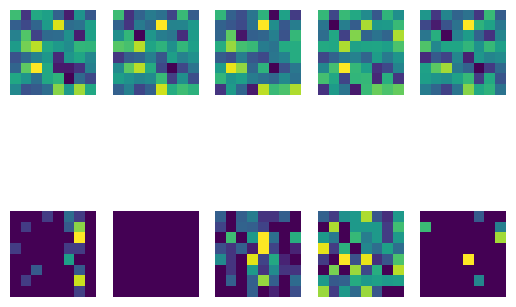

1000 tensor(0.2669, device='cuda:0', grad_fn=<MseLossBackward0>)


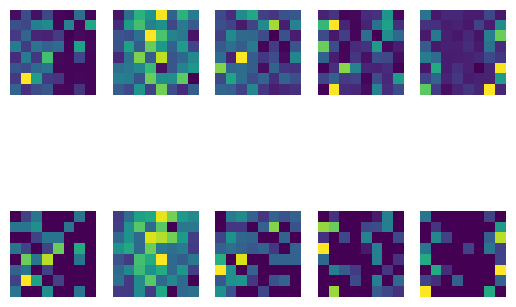

2000 tensor(0.2183, device='cuda:0', grad_fn=<MseLossBackward0>)


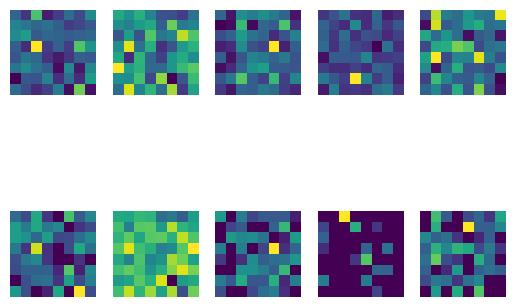

3000 tensor(0.1832, device='cuda:0', grad_fn=<MseLossBackward0>)


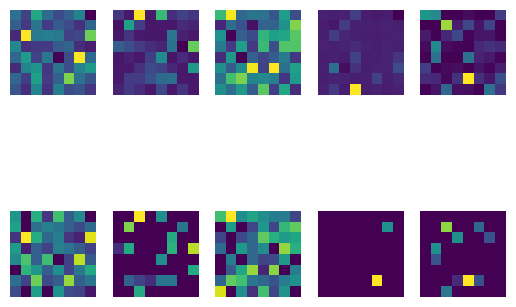

4000 tensor(0.1515, device='cuda:0', grad_fn=<MseLossBackward0>)


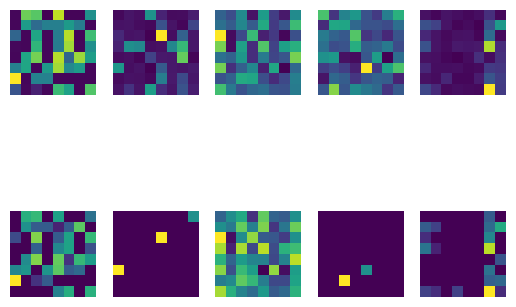

5000 tensor(0.1892, device='cuda:0', grad_fn=<MseLossBackward0>)


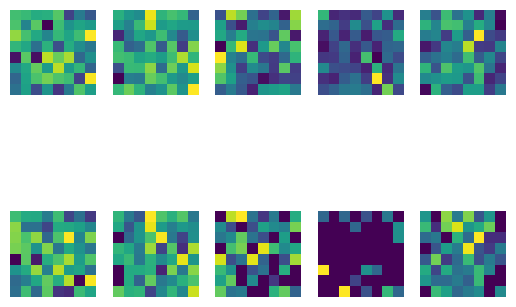

6000 tensor(0.1838, device='cuda:0', grad_fn=<MseLossBackward0>)


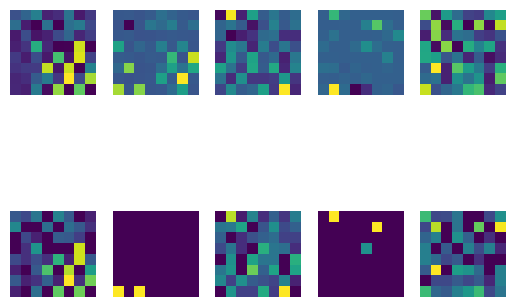

7000 tensor(0.1650, device='cuda:0', grad_fn=<MseLossBackward0>)


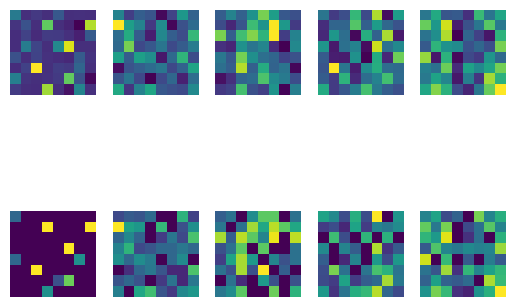

8000 tensor(0.1725, device='cuda:0', grad_fn=<MseLossBackward0>)


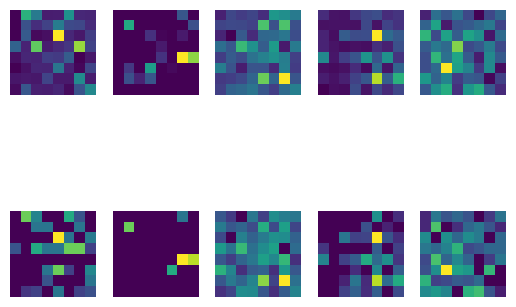

9000 tensor(0.1670, device='cuda:0', grad_fn=<MseLossBackward0>)


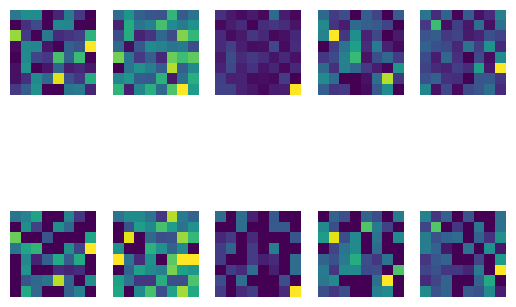

10000 tensor(0.1833, device='cuda:0', grad_fn=<MseLossBackward0>)


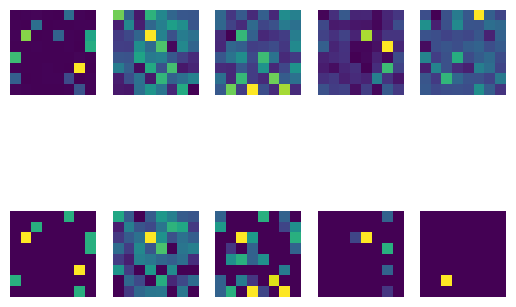

11000 tensor(0.2067, device='cuda:0', grad_fn=<MseLossBackward0>)


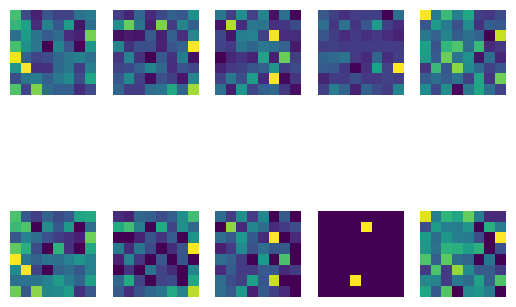

12000 tensor(0.1723, device='cuda:0', grad_fn=<MseLossBackward0>)


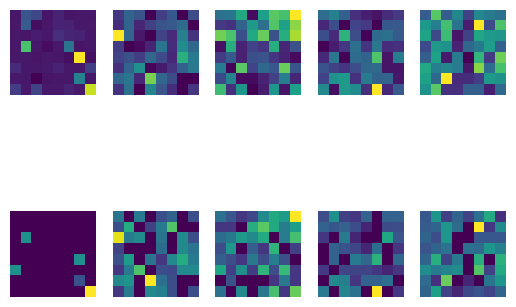

13000 tensor(0.1527, device='cuda:0', grad_fn=<MseLossBackward0>)


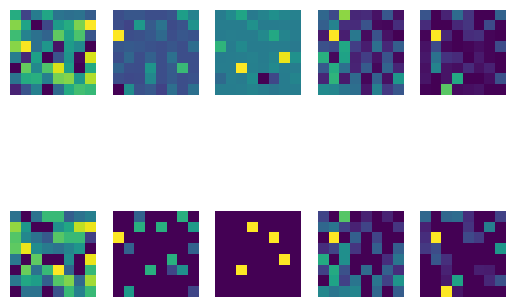

14000 tensor(0.1794, device='cuda:0', grad_fn=<MseLossBackward0>)


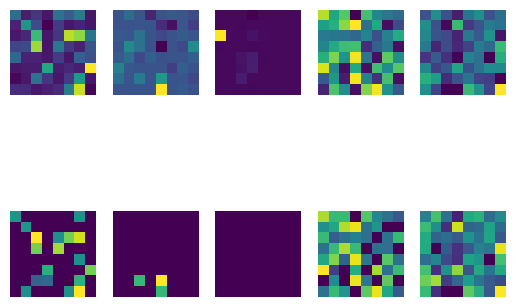

15000 tensor(0.1535, device='cuda:0', grad_fn=<MseLossBackward0>)


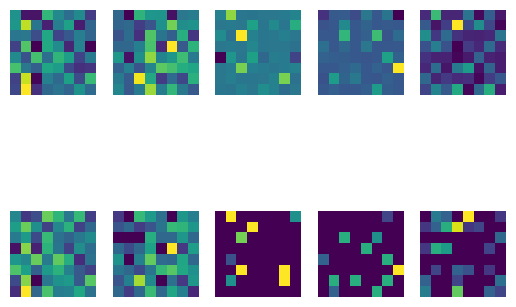

16000 tensor(0.1718, device='cuda:0', grad_fn=<MseLossBackward0>)


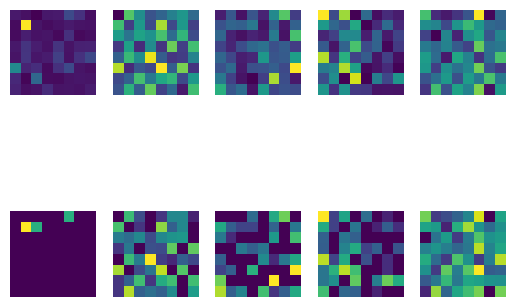

17000 tensor(0.1839, device='cuda:0', grad_fn=<MseLossBackward0>)


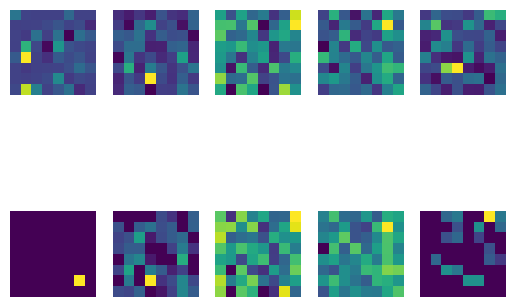

18000 tensor(0.1716, device='cuda:0', grad_fn=<MseLossBackward0>)


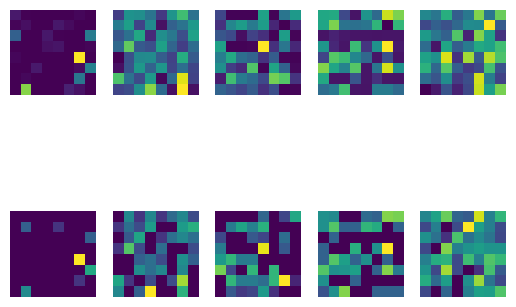

19000 tensor(0.1652, device='cuda:0', grad_fn=<MseLossBackward0>)


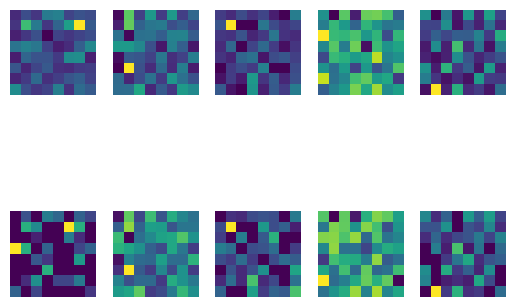

20000 tensor(0.1705, device='cuda:0', grad_fn=<MseLossBackward0>)


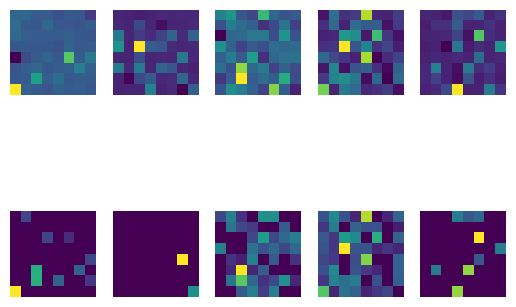

21000 tensor(0.1656, device='cuda:0', grad_fn=<MseLossBackward0>)


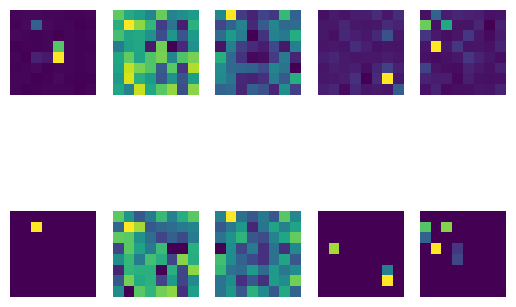

22000 tensor(0.1741, device='cuda:0', grad_fn=<MseLossBackward0>)


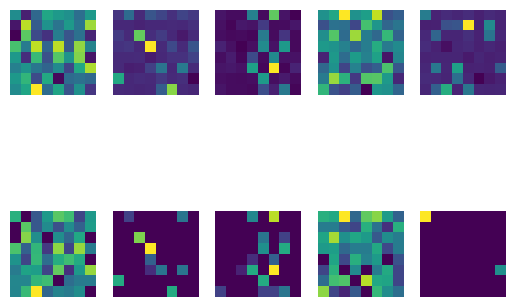

23000 tensor(0.1686, device='cuda:0', grad_fn=<MseLossBackward0>)


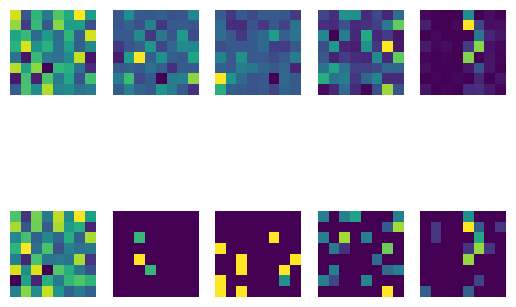

24000 tensor(0.1854, device='cuda:0', grad_fn=<MseLossBackward0>)


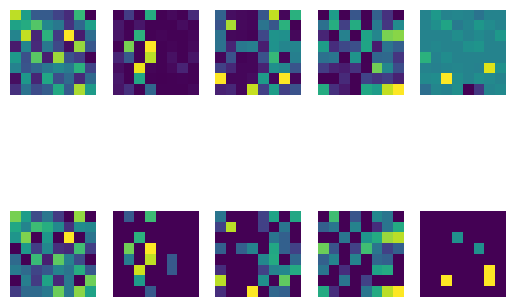

25000 tensor(0.1874, device='cuda:0', grad_fn=<MseLossBackward0>)


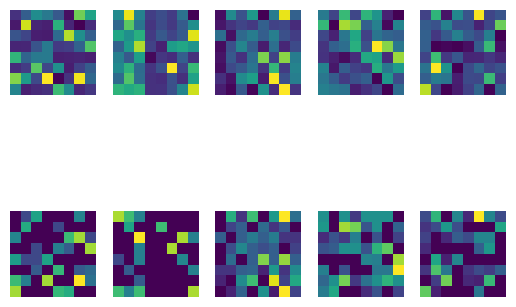

26000 tensor(0.1876, device='cuda:0', grad_fn=<MseLossBackward0>)


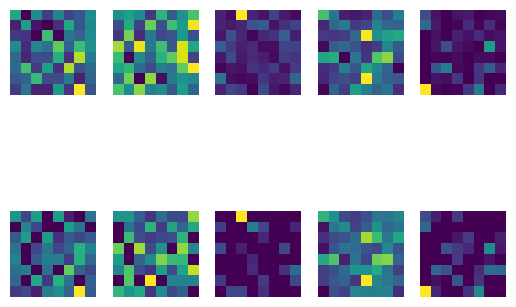

27000 tensor(0.1813, device='cuda:0', grad_fn=<MseLossBackward0>)


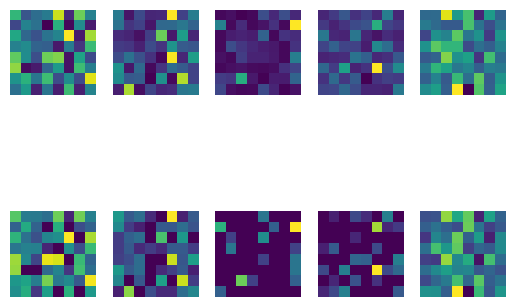

28000 tensor(0.1590, device='cuda:0', grad_fn=<MseLossBackward0>)


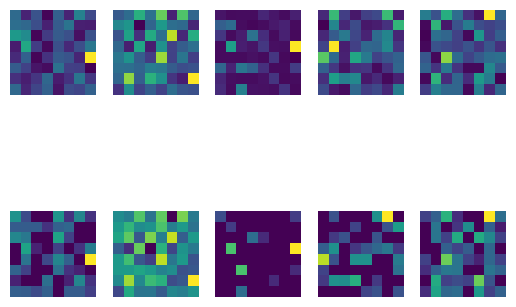

29000 tensor(0.1706, device='cuda:0', grad_fn=<MseLossBackward0>)


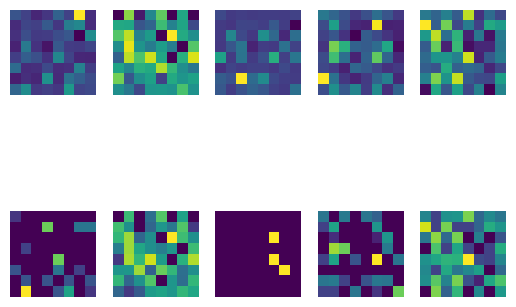

30000 tensor(0.1503, device='cuda:0', grad_fn=<MseLossBackward0>)


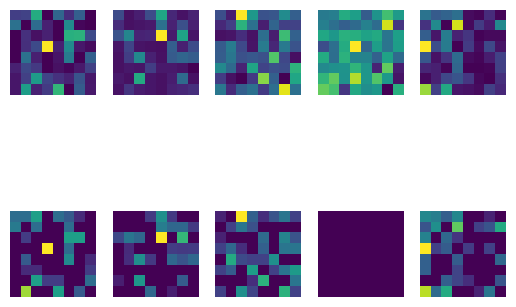

31000 tensor(0.1443, device='cuda:0', grad_fn=<MseLossBackward0>)


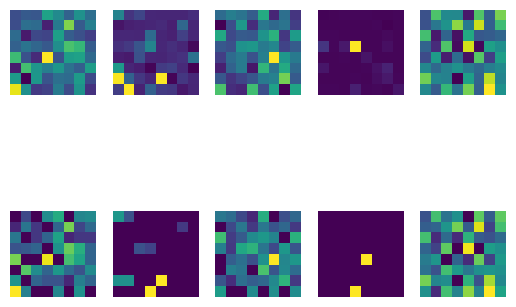

32000 tensor(0.1566, device='cuda:0', grad_fn=<MseLossBackward0>)


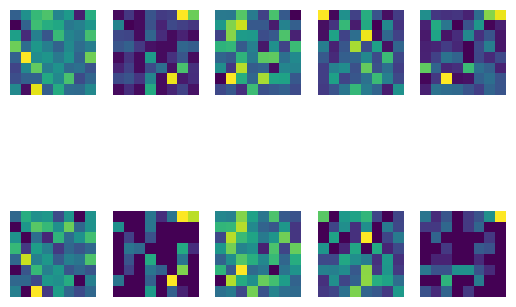

33000 tensor(0.1614, device='cuda:0', grad_fn=<MseLossBackward0>)


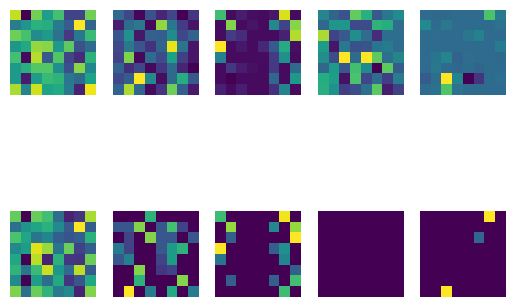

34000 tensor(0.1698, device='cuda:0', grad_fn=<MseLossBackward0>)


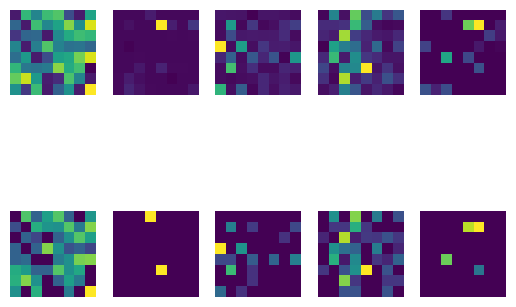

35000 tensor(0.1778, device='cuda:0', grad_fn=<MseLossBackward0>)


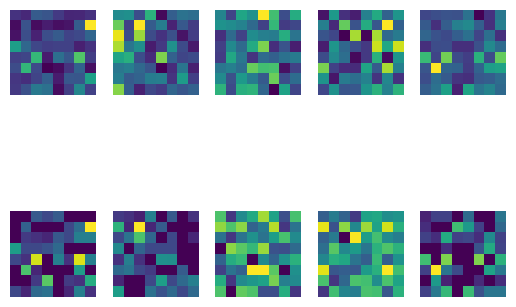

36000 tensor(0.1756, device='cuda:0', grad_fn=<MseLossBackward0>)


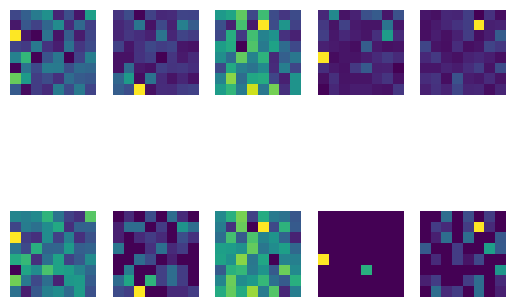

37000 tensor(0.1756, device='cuda:0', grad_fn=<MseLossBackward0>)


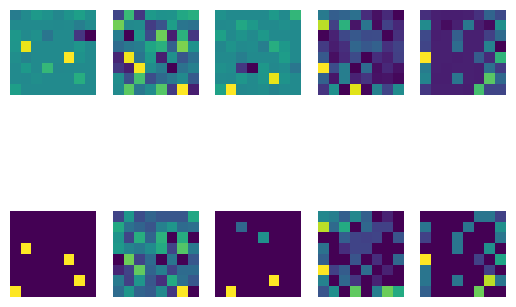

38000 tensor(0.1550, device='cuda:0', grad_fn=<MseLossBackward0>)


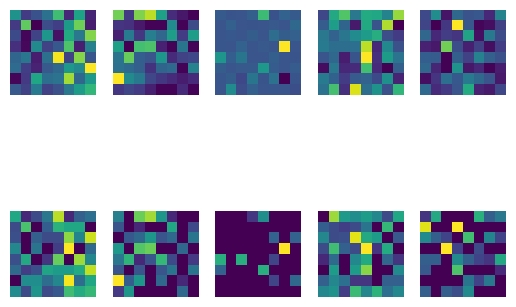

39000 tensor(0.1843, device='cuda:0', grad_fn=<MseLossBackward0>)


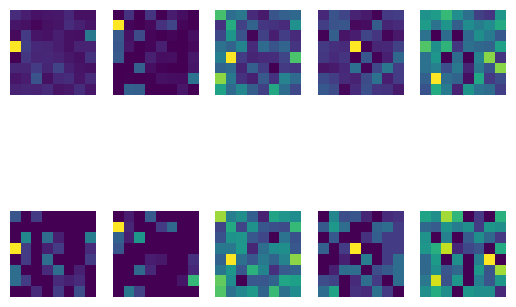

40000 tensor(0.1724, device='cuda:0', grad_fn=<MseLossBackward0>)


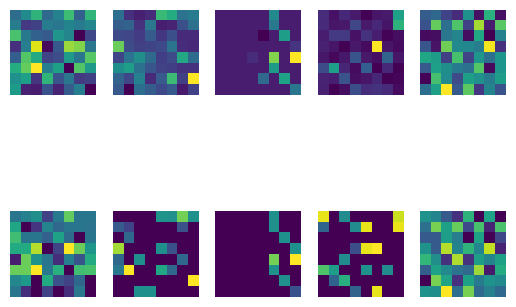

41000 tensor(0.1522, device='cuda:0', grad_fn=<MseLossBackward0>)


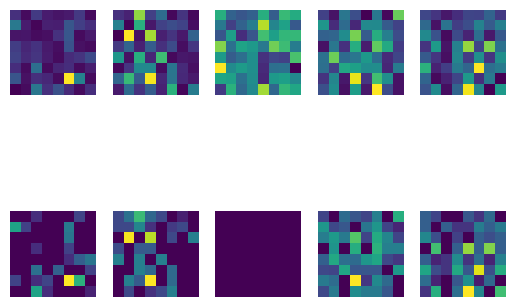

42000 tensor(0.1736, device='cuda:0', grad_fn=<MseLossBackward0>)


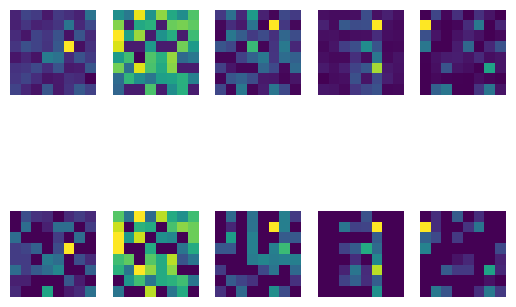

43000 tensor(0.1646, device='cuda:0', grad_fn=<MseLossBackward0>)


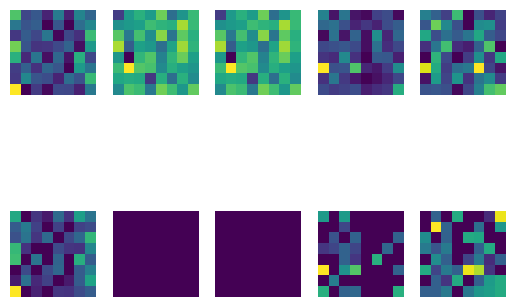

44000 tensor(0.1753, device='cuda:0', grad_fn=<MseLossBackward0>)


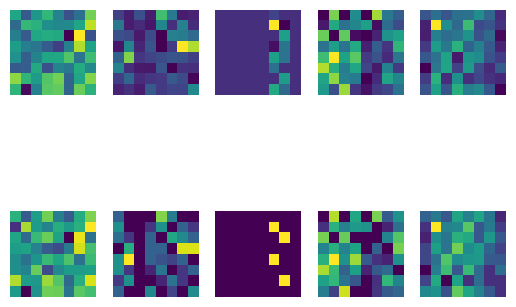

45000 tensor(0.1576, device='cuda:0', grad_fn=<MseLossBackward0>)


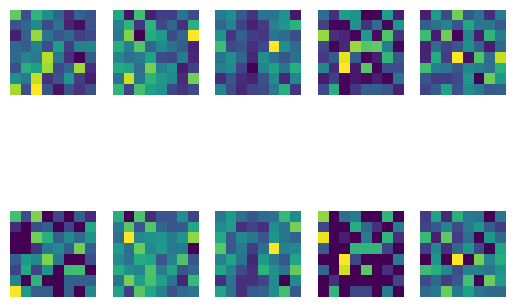

46000 tensor(0.1759, device='cuda:0', grad_fn=<MseLossBackward0>)


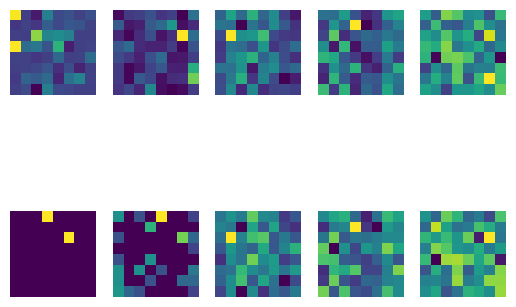

KeyboardInterrupt: 

In [27]:
for i, b in enumerate(dl):
    opt.zero_grad()
    
    slide_idxs, imgs = b['slide_idx'], b['img']
    slide_idxs, imgs = slide_idxs.cuda(), imgs.cuda()
    loss, pred_pixel_values = mae(imgs, slide_idxs)
    loss.backward()
    opt.step()
    
    if i % 1000 == 0:
        print(i, loss)
        
        pred_patches = rearrange(
            pred_pixel_values, 'b (h w) (p1 p2 c) -> b c (h p1) (w p2)',
            h=8, w=8, p1=1, p2=1, c=len(channels))
        
        fig, axs = plt.subplots(nrows=2, ncols=5)
        for c in range(axs.shape[1]):
            ax1, ax2 = axs[:, c]
            ax1.imshow(pred_patches[c, channel_idx].cpu().detach())
            ax1.axis('off')
            ax2.imshow(imgs[c, channel_idx].cpu().detach())
            ax2.axis('off')
            if c==0:
                ax1.set_ylabel('pred')
                ax2.set_ylabel('true')
        plt.show()
            
        
    if i % 5000 == 0:
        torch.save(mae.state_dict(), f'../data/mae_v5/{i}iter.pt')
        
    if i == iters:
        break

In [61]:
# torch.save(v.state_dict(), f'../data/mae_v3/1500iter.pt')

In [21]:
mae.load_state_dict(torch.load('../data/mae_v5/45000iter.pt'))

<All keys matched successfully>

In [22]:
size = (256, 256)

normalize = Normalize(means, stds)
transform = InferenceTransformVisium(size=(256, 256), patch_size=32, normalize=normalize)
inference_ds = InferenceSlideDatasetVisium(slide_to_adata, size=(256, 256), transform=transform, crop=False)

/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525541990/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [23]:
inference_dl = DataLoader(inference_ds, batch_size=32, shuffle=False)

In [24]:
x = inference_ds.image_from_tiles(inference_ds.slide_to_tiles[inference_ds.slides[0]],
                                  to_expression=True, adata=inference_ds.slide_to_adata['s0'])
x.shape

torch.Size([11630, 52, 52])

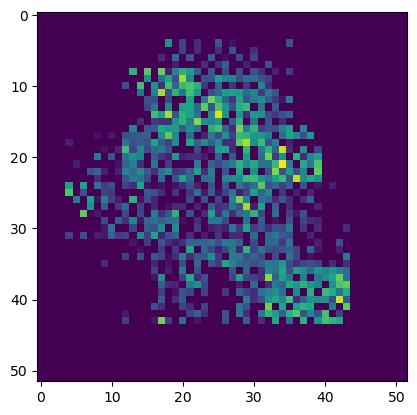

In [25]:
plt.imshow(x[channels.index('EPCAM')])

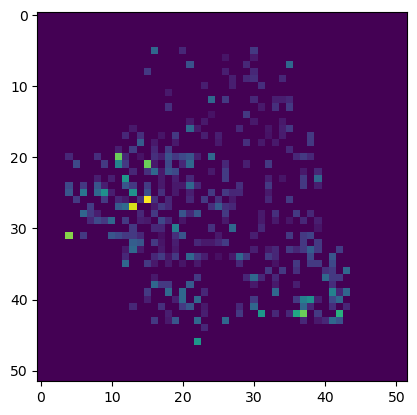

In [26]:
plt.imshow(x[channels.index('IL7R')])

In [27]:
d = inference_ds[0]
d.keys()

dict_keys(['slide_idx', 'row_idx', 'col_idx', 'img'])

In [28]:
d['img'].shape

torch.Size([11630, 8, 8])

In [29]:
v = ViT(
    image_size = 8,
    patch_size = 1,
    num_classes = 1000,
    dim = 1024,
    depth = 6,
    heads = 8,
    mlp_dim = 2048,
    channels=len(channels),
)

In [30]:
mae = SlideMAEV2(
    encoder = v,
    n_slides = len(slide_to_adata),
    decoder_dim = 512,      # paper showed good results with just 512
    decoder_depth = 6       # anywhere from 1 to 8
)

In [31]:
mae.load_state_dict(torch.load('../data/mae_v5/6000iter.pt'))

<All keys matched successfully>

In [32]:
mae.eval()

SlideMAEV2(
  (encoder): ViT(
    (to_patch_embedding): Sequential(
      (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=1, p2=1)
      (1): LayerNorm((11630,), eps=1e-05, elementwise_affine=True)
      (2): Linear(in_features=11630, out_features=1024, bias=True)
      (3): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    )
    (dropout): Dropout(p=0.0, inplace=False)
    (transformer): Transformer(
      (layers): ModuleList(
        (0): ModuleList(
          (0): PreNorm(
            (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (fn): Attention(
              (attend): Softmax(dim=-1)
              (dropout): Dropout(p=0.0, inplace=False)
              (to_qkv): Linear(in_features=1024, out_features=1536, bias=False)
              (to_out): Sequential(
                (0): Linear(in_features=512, out_features=1024, bias=True)
                (1): Dropout(p=0.0, inplace=False)
              )
            )
          )
          (1):

In [33]:
all_encoded_tokens = torch.zeros(len(inference_ds), size[0] // 32, size[1] // 32, v.pos_embedding.shape[-1])
all_decoded_tokens = torch.zeros(len(inference_ds), size[0] // 32, size[1] // 32, mae.decoder_dim)
all_pred_patches = torch.zeros(len(inference_ds), len(channels), size[0] // 32, size[1] // 32)
bs = inference_dl.batch_size
with torch.no_grad():
    for i, b in enumerate(inference_dl):
        x, slide_idx = b['img'], b['slide_idx']
        if v.pos_embedding.is_cuda:
            x, slide_idx = x.to(v.pos_embedding.device), slide_idx.to(v.pos_embedding.device)
        
        encoded_tokens = mae.encode(x, slide_idx)
        decoded_tokens = mae.decode(encoded_tokens)
        pred_pixel_values = mae.to_pixels(decoded_tokens[:, 1:])

        encoded_tokens = rearrange(encoded_tokens[:, 1:], 'b (h w) d -> b h w d',
                                  h=size[0] // 32, w=size[1] // 32)
        decoded_tokens = rearrange(decoded_tokens[:, 1:], 'b (h w) d -> b h w d',
                                  h=size[0] // 32, w=size[1] // 32)
        pred_patches = rearrange(
            pred_pixel_values, 'b (h w) (p1 p2 c) -> b c (h p1) (w p2)',
            h=size[0] // 32, w=size[0] // 32, p1=1, p2=1, c=len(channels))
        
        all_encoded_tokens[i * bs:(i + 1) * bs] = encoded_tokens.cpu().detach()
        all_decoded_tokens[i * bs:(i + 1) * bs] = decoded_tokens.cpu().detach()
        all_pred_patches[i * bs:(i + 1) * bs] = pred_patches.cpu().detach()

In [34]:
all_encoded_tokens.shape, all_decoded_tokens.shape, all_pred_patches.shape

(torch.Size([338, 8, 8, 1024]),
 torch.Size([338, 8, 8, 512]),
 torch.Size([338, 11630, 8, 8]))

In [43]:
d = {
    'encoded_tokens': all_encoded_tokens,
    'decoded_tokens': all_decoded_tokens,
    'predicted_patches': all_pred_patches,
    'idx_to_coord': inference_ds.idx_to_coord
}
torch.save(d, '../data/mae_v5/outputs.pt')

In [35]:
x = inference_ds.slide_from_tiles(all_pred_patches, 0, size=all_pred_patches.shape[-2:])
x.shape

torch.Size([11630, 52, 52])

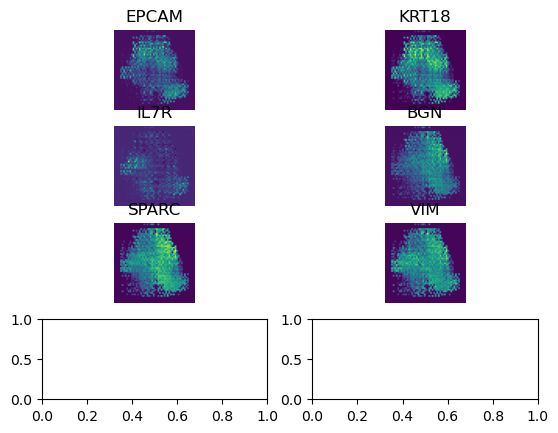

In [36]:
genes = [
    'EPCAM', 'KRT18',
    'IL7R',
    'BGN', 'SPARC', 'VIM',
]
n_cols = 2
n_rows = len(genes) // n_cols + 1
rc = [(i, j) for i in range(n_rows) for j in range(n_cols)]

fig, axs = plt.subplots(ncols=n_cols, nrows=n_rows)
rc = [(i, j) for i in range(n_rows) for j in range(n_cols)]
for (row_idx, col_idx), c in zip(rc, genes):
    ax = axs[row_idx, col_idx]
    ax.imshow(x[channels.index(c)])
    ax.axis('off')
    ax.set_title(c)

In [37]:
all_encoded_tokens.shape

torch.Size([338, 8, 8, 1024])

In [38]:
# testing regressing out tokens

In [39]:
import statsmodels.api as sm

In [40]:
# data = sm.datasets.scotland.load()
# data.exog = sm.add_constant(data.exog)

# gamma_model = sm.GLM(data.endog, data.exog, family=sm.families.Gamma())
# gamma_results = gamma_model.fit()



In [41]:
# gamma_results.summary()

In [42]:
from sklearn.linear_model import LinearRegression

In [320]:
x = all_encoded_tokens.clone()
x = rearrange(x, 'n h w d -> (n h w) d')
x = x.numpy()
x.shape

(21632, 1024)

In [321]:
regressors = torch.zeros(all_encoded_tokens.shape[:-1], dtype=torch.long).unsqueeze(-1)
idx_to_var = [(r, c) for r in range(regressors.shape[1]) for c in range(regressors.shape[2])]
var_to_idx = {v:i for i, v in enumerate(idx_to_var)}
for i, (slide_idx, row_idx, col_idx) in enumerate(inference_ds.idx_to_coord):
    for r in range(regressors.shape[1]):
        for c in range(regressors.shape[2]):
            regressors[i, r, c] = var_to_idx[(r, c)]
target = rearrange(regressors, 'n h w d -> (n h w) d').squeeze()
target = torch.nn.functional.one_hot(target).numpy()
# target = target.numpy()
target.shape

(21632, 64)

In [322]:
# idxs = np.random.choice(np.arange(target.shape[0]), size=1000, replace=False)
# x = x[idxs]
# target = target[idxs]
# x.shape, target.shape

In [327]:
# lm = LinearRegression()
# lm.fit(x, target)
# residuals = lm.predict(x) - target
# residuals.shape

(21632, 64)

In [328]:
lm = LinearRegression()
lm.fit(target, x)
residuals = lm.predict(target) - x
residuals.shape

(21632, 1024)

In [331]:
x = torch.tensor(residuals)
x.shape

torch.Size([21632, 1024])

In [332]:
clusterer = KMeans(n_clusters=20)
cluster_ids = clusterer.fit_transform(x.numpy())
cluster_ids = torch.tensor(cluster_ids.argmin(1))
cluster_ids.shape

torch.Size([21632])

In [334]:
cluster_imgs = rearrange(cluster_ids, '(n h w) -> n 1 h w',
                        n=all_encoded_tokens.shape[0], h=all_encoded_tokens.shape[1], w=all_encoded_tokens.shape[2])
labeled_img = inference_ds.slide_from_tiles(
    cluster_imgs, 0, size=(cluster_imgs.shape[-2], cluster_imgs.shape[-1])).squeeze().to(torch.long)

stacked_labeled = []
for i in range(len(slide_to_adata)):
    stacked_labeled.append(inference_ds.slide_from_tiles(
        cluster_imgs, i, size=(cluster_imgs.shape[-2], cluster_imgs.shape[-1])).squeeze().to(torch.long))
stacked_labeled = torch.stack(stacked_labeled)
stacked_labeled.shape

torch.Size([2, 52, 52])

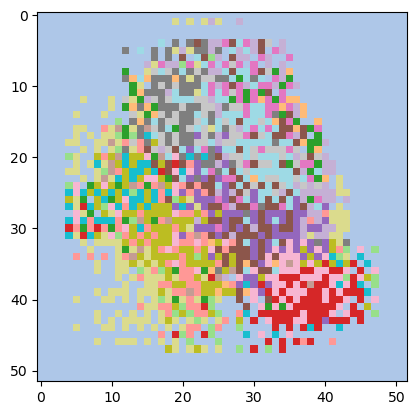

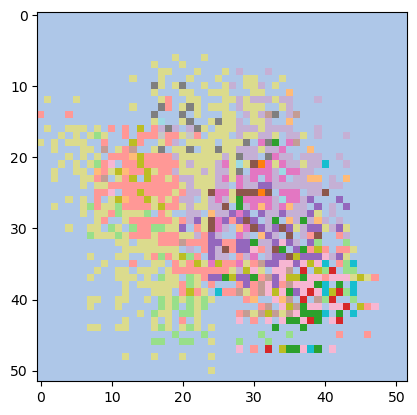

In [335]:
cmap = sns.color_palette('tab20')
for i, labeled in enumerate(stacked_labeled):
    plt.imshow(display_labeled_as_rgb(labeled, cmap=cmap))
    plt.show()

In [336]:
cmap

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (1.0, 0.7333333333333333, 0.47058823529411764),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (1.0, 0.596078431372549, 0.5882352941176471),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7803921568627451, 0.7803921568627451, 0.7803921568627451),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.8588235294117647, 0.8588235294117647, 0.5529411764705883),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.6196078431372549, 0.8549019607843137, 0.8980392156862745)]

In [337]:
cluster = 20

In [ ]:
to_labeled = torch.zeros(338, 8, 8, 1, dtype=torch.long)
idx_to_str = {}
idx = 0
for i, (slide_idx, row_idx, col_idx) in enumerate(inference_ds.idx_to_coord):
    for r in range(labeled.shape[1]):
        for c in range(labeled.shape[2]):
            idx_to_str[idx] = f'slide{slide_idx}_row{row_idx}_col{col_idx}_{r}_{c}'
            labeled[i, r, c] = idx
            idx += 1
labeled.shape

In [339]:
z = inference_ds.slide_to_tiles['s0']
z.shape

torch.Size([13, 13, 1, 256, 256])

In [340]:
z = inference_ds.slide_to_labeled['s0']
z.shape

torch.Size([1573, 1551])

In [353]:
a = slide_to_adata['s3']
a

AnnData object with n_obs × n_vars = 2340 × 11630
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'he_rescaled', 'he_rescaled_warped', 'spatial', 'label_to_barcode', 'barcode_to_label', 'log1p'
    obsm: 'he_rescaled_spatial', 'spatial', 'spatial_original', 'spatial_scaled'

In [354]:
sc.pp.calculate_qc_metrics(a, inplace=True)

In [355]:
a

AnnData object with n_obs × n_vars = 2340 × 11630
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'he_rescaled', 'he_rescaled_warped', 'spatial', 'label_to_barcode', 'barcode_to_label', 'log1p'
    obsm: 'he_rescaled_spatial', 'spatial', 'spatial_original', 'spatial_scaled'

In [356]:
a.obs

,in_tissue,array_row,array_col,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes
AAACAGAGCGACTCCT-1,1,14,94,3109,8.042378,2750.457275,7.919886,4.398444,7.762162,13.607793,27.483890
AAACAGCTTTCAGAAG-1,1,43,9,51,3.951244,36.161430,3.615271,98.083191,100.000000,100.000000,100.000000
AAACAGTGTTCCTGGG-1,1,73,43,92,4.532599,67.706406,4.229843,57.002354,100.000079,100.000079,100.000079
AAACCGGGTAGGTACC-1,1,42,28,209,5.347108,152.675842,5.034845,27.814142,50.514144,95.914089,100.000090
AAACCGTTCGTCCAGG-1,1,52,42,3903,8.269757,3733.689453,8.225420,3.898657,6.813712,11.796795,23.933187
...,...,...,...,...,...,...,...,...,...,...,...
TTGTTCAGTGTGCTAC-1,1,24,64,5105,8.538172,5116.640137,8.540449,3.230641,5.632273,9.828916,20.123850
TTGTTGTGTGTCAAGA-1,1,31,77,3268,8.092239,2944.963867,7.988192,4.848655,8.222813,13.916974,27.457143
TTGTTTCACATCCAGG-1,1,58,42,4894,8.495970,5024.913086,8.522363,3.276309,5.821087,10.211842,20.968824
TTGTTTCATTAGTCTA-1,1,60,30,423,6.049733,323.153961,5.781219,19.491735,30.718357,52.167811,100.000057


/tmp/ipykernel_3078691/816232611.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(a.obs['n_genes_by_counts'])


<AxesSubplot:xlabel='n_genes_by_counts', ylabel='Density'>

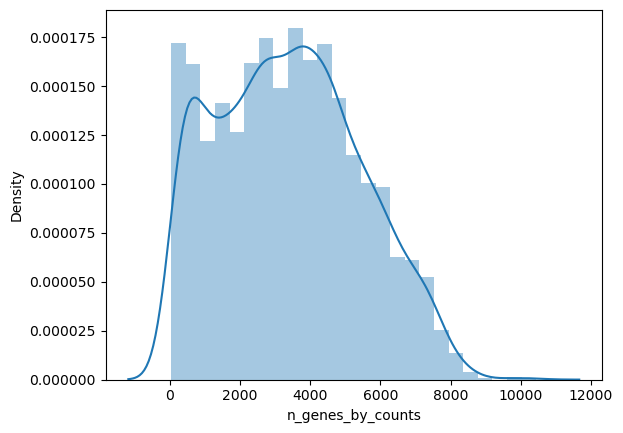

In [351]:
sns.distplot(a.obs['n_genes_by_counts'])

/tmp/ipykernel_3078691/816232611.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(a.obs['n_genes_by_counts'])


<AxesSubplot:xlabel='n_genes_by_counts', ylabel='Density'>

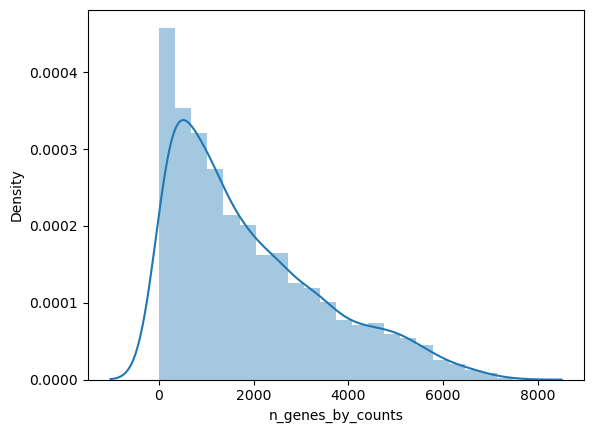

In [357]:
sns.distplot(a.obs['n_genes_by_counts'])

In [266]:
x = all_encoded_tokens.clone()
x = rearrange(x, 'n h w d -> (n h w) d')
# x /= x.std(0)

In [267]:
from sklearn.cluster import KMeans
clusterer = KMeans(n_clusters=20)
cluster_ids = clusterer.fit_transform(x.numpy())
cluster_ids = torch.tensor(cluster_ids.argmin(1))
cluster_ids.shape

torch.Size([21632])

In [268]:
# num_clusters = 20
# cluster_ids, cluster_centers = kmeans(
#     X=x, num_clusters=num_clusters, distance='euclidean', device=torch.device('cuda:1'), tol=1.,
# )
# cluster_ids = cluster_ids.cpu().detach()

In [269]:
cluster_imgs = rearrange(cluster_ids, '(n h w) -> n 1 h w',
                        n=all_encoded_tokens.shape[0], h=all_encoded_tokens.shape[1], w=all_encoded_tokens.shape[2])
labeled_img = inference_ds.slide_from_tiles(
    cluster_imgs, 0, size=(cluster_imgs.shape[-2], cluster_imgs.shape[-1])).squeeze().to(torch.long)
labeled_img.shape

torch.Size([52, 52])

In [270]:
def display_labeled_as_rgb(labeled, cmap=None):
    if isinstance(labeled, torch.Tensor):
        labeled = labeled.numpy()
    cmap = sns.color_palette() if cmap is None else cmap
    labels = sorted(np.unique(labeled))
    if len(cmap) < len(labels):
        raise RuntimeError('cmap is too small')
    new = np.zeros((labeled.shape[0], labeled.shape[1], 3))
    for l in labels:
        c = cmap[l]
        new[labeled==l] = c
    return new

In [271]:
stacked_labeled = []
for i in range(len(slide_to_adata)):
    stacked_labeled.append(inference_ds.slide_from_tiles(
        cluster_imgs, i, size=(cluster_imgs.shape[-2], cluster_imgs.shape[-1])).squeeze().to(torch.long))
stacked_labeled = torch.stack(stacked_labeled)
stacked_labeled.shape

torch.Size([2, 52, 52])

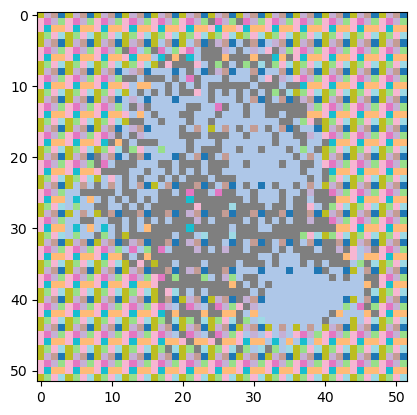

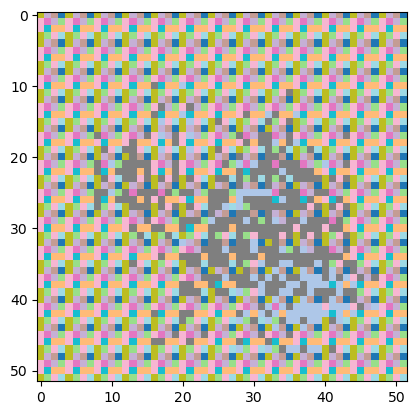

In [272]:
cmap = sns.color_palette('tab20')
for i, labeled in enumerate(stacked_labeled):
    plt.imshow(display_labeled_as_rgb(labeled, cmap=cmap))
    plt.show()

In [202]:
size = (256, 256)

In [203]:
shape = inference_ds.slide_to_labeled['s0'].shape
shape

torch.Size([1573, 1551])

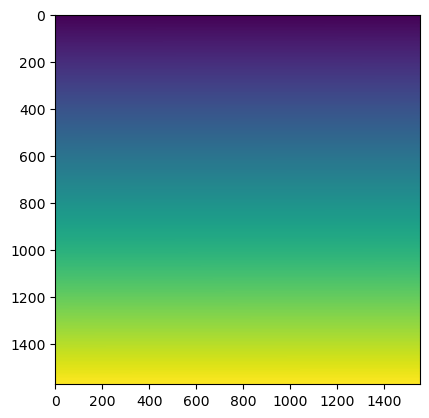

In [204]:
labeled = torch.arange(shape[0] * shape[1])
labeled = rearrange(labeled, '(h w) -> h w', h=shape[0], w=shape[1])
plt.imshow(labeled)

In [205]:
tiles = inference_ds.to_tiles(labeled.unsqueeze(0))
tiles.shape

torch.Size([13, 13, 1, 256, 256])

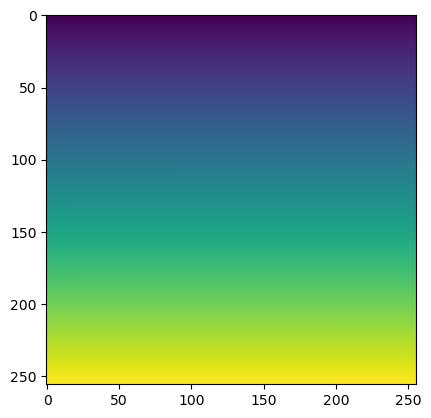

In [207]:
plt.imshow(tiles[6, 8, 0])

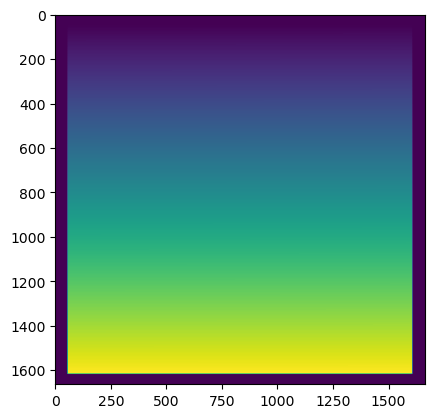

In [211]:
out = inference_ds.image_from_tiles(tiles).squeeze()
plt.imshow(out)

In [212]:
338, 8, 8, 1024

torch.Size([13, 13, 1, 256, 256])

In [233]:
labeled = torch.zeros(338, 8, 8, 1, dtype=torch.long)
idx_to_str = {}
idx = 0
for i, (slide_idx, row_idx, col_idx) in enumerate(inference_ds.idx_to_coord):
    for r in range(labeled.shape[1]):
        for c in range(labeled.shape[2]):
            idx_to_str[idx] = f'slide{slide_idx}_row{row_idx}_col{col_idx}_{r}_{c}'
            labeled[i, r, c] = idx
            idx += 1
labeled.shape

torch.Size([338, 8, 8, 1])

In [234]:
idx_to_str[labeled[10, 1, 1, 0].item()]

'slide0_row0_col10_1_1'

In [235]:
pre_cluster_labeled = rearrange(labeled, 'n h w d -> (n h w) d')
pre_cluster_labeled.shape

torch.Size([21632, 1])

In [236]:
post_cluster_labeled = pre_cluster_labeled.squeeze()
post_cluster_labeled.shape

torch.Size([21632])

In [237]:
post_cluster_image = rearrange(post_cluster_labeled, '(n h w) -> n 1 h w',
                        n=all_encoded_tokens.shape[0], h=all_encoded_tokens.shape[1], w=all_encoded_tokens.shape[2])
post_cluster_image.shape

torch.Size([338, 1, 8, 8])

In [238]:
slide_from_tiles_img = inference_ds.slide_from_tiles(
    post_cluster_image, 0, size=(post_cluster_image.shape[-2], post_cluster_image.shape[-1])).squeeze().to(torch.long)
slide_from_tiles_img.shape

torch.Size([52, 52])

In [242]:
idx = slide_from_tiles_img[0, 0].item()
idx_to_str[idx]

'slide0_row0_col0_2_2'

In [246]:
idx = slide_from_tiles_img[4, 0].item()
idx_to_str[idx]

'slide0_row1_col0_2_2'

In [247]:
idx = slide_from_tiles_img[33, 44].item()
idx_to_str[idx]

'slide0_row8_col11_3_2'

In [248]:
8 * 4

32

In [122]:
tiles = inference_ds.slide_to_tiles['s0']
tiles.shape

torch.Size([13, 13, 1, 256, 256])

In [133]:
mask = torch.zeros(len(inference_ds.idx_to_coord), 8, 8, dtype=torch.bool)
for i, (slide_idx, row_idx, col_idx) in enumerate(inference_ds.idx_to_coord):
    slide = inference_ds.slides[slide_idx]
    labeled_tile = inference_ds.slide_to_tiles[slide][row_idx, col_idx, 0]
    labeled_tile = rearrange(labeled_tile, '(ph h) (pw w) -> h w (ph pw)', ph=32, pw=32)
    mask[i] = labeled_tile.sum(dim=-1) > 0
mask.shape

torch.Size([338, 8, 8])

In [139]:
mask[60]

tensor([[ True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True, False],
        [ True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True]])

In [127]:
# slide_to_hulls = {}
# for slide in inference_ds.slides:
#     x = inference_ds.image_from_tiles(inference_ds.slide_to_tiles[slide]).squeeze()
#     z = 52 / x.shape[0]
#     pts = (x!=0).argwhere().to(torch.float32)
#     pts *= z
#     pts = pts.to(torch.long)
    
#     mask = np.zeros((52, 52))
#     for r, c in pts:
#         mask[r, c] = True
#     slide_to_hulls[slide] = mask
# #     hull = convex_hull_image(mask)
# #     slide_to_hulls[slide] = hull
# for slide, hull in slide_to_hulls.items():
#     plt.imshow(hull)
#     plt.title(slide)
#     plt.show()

In [195]:
zzz = mask.unsqueeze(1)
zzz_img = inference_ds.slide_from_tiles(
    zzz, 0, size=(zzz.shape[-2], zzz.shape[-1])).squeeze().to(torch.long)
zzz_img.shape

torch.Size([52, 52])

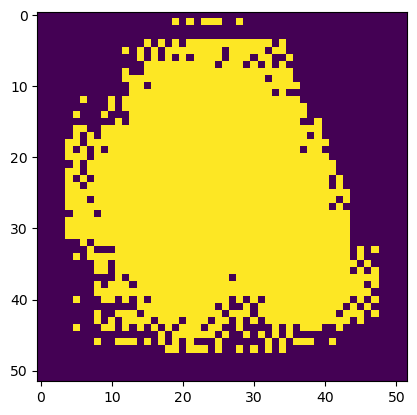

In [196]:
plt.imshow(zzz_img)

In [160]:
x = all_encoded_tokens.clone()
x[~mask] = torch.zeros(x.shape[-1])
x = rearrange(x, 'n h w d -> (n h w) d')
x /= x.std(0)

In [161]:
(x.sum(-1)==0).sum()

tensor(12181)

In [171]:
x

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [183]:
from sklearn.cluster import KMeans
clusterer = KMeans(n_clusters=10)
cluster_ids = clusterer.fit_transform(x.numpy())
cluster_ids.shape

(21632, 10)

In [184]:
cluster_ids = cluster_ids.argmin(1)
np.unique(cluster_ids, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([20215,   160,   160,   150,   170,   152,   149,   150,   175,
          151]))

In [185]:
cluster_ids = torch.tensor(cluster_ids)

In [186]:
# num_clusters = 5
# cluster_ids, cluster_centers = kmeans(
#     X=x, num_clusters=num_clusters, distance='euclidean', device=torch.device('cuda:1'), tol=1.,
# )

In [187]:
# cluster_ids, cluster_centers = cluster_ids.cpu().detach(), cluster_centers.cpu().detach()

In [188]:
# cluster_ids.shape, cluster_centers.shape

In [189]:
cluster_imgs = rearrange(cluster_ids, '(n h w) -> n 1 h w',
                        n=all_encoded_tokens.shape[0], h=all_encoded_tokens.shape[1], w=all_encoded_tokens.shape[2])
cluster_imgs.shape

torch.Size([338, 1, 8, 8])

In [190]:
labeled_img = inference_ds.slide_from_tiles(
    cluster_imgs, 0, size=(cluster_imgs.shape[-2], cluster_imgs.shape[-1])).squeeze().to(torch.long)
labeled_img.shape

torch.Size([52, 52])

In [191]:
labeled_img

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [192]:
def display_labeled_as_rgb(labeled, cmap=None):
    if isinstance(labeled, torch.Tensor):
        labeled = labeled.numpy()
    cmap = sns.color_palette() if cmap is None else cmap
    labels = sorted(np.unique(labeled))
    if len(cmap) < len(labels):
        raise RuntimeError('cmap is too small')
    new = np.zeros((labeled.shape[0], labeled.shape[1], 3))
    for l in labels:
        c = cmap[l]
        new[labeled==l] = c
    return new

In [193]:
import seaborn as sns

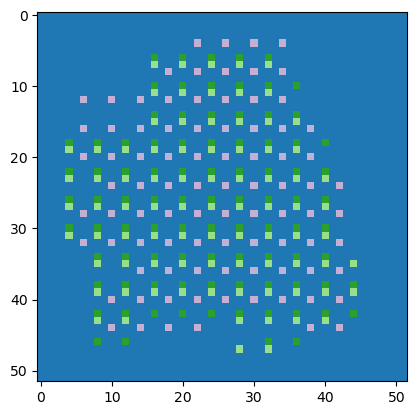

In [194]:
# cmap = sns.color_palette('tab20') + sns.color_palette('tab20b') + sns.color_palette('tab20c')
cmap = sns.color_palette('tab20')
plt.imshow(display_labeled_as_rgb(labeled_img, cmap=cmap))

In [47]:
stacked_labeled = []
for i in range(len(slide_to_adata)):
    stacked_labeled.append(inference_ds.slide_from_tiles(
        cluster_imgs, i, size=(cluster_imgs.shape[-2], cluster_imgs.shape[-1])).squeeze().to(torch.long))
stacked_labeled = torch.stack(stacked_labeled)
stacked_labeled.shape

torch.Size([2, 52, 52])

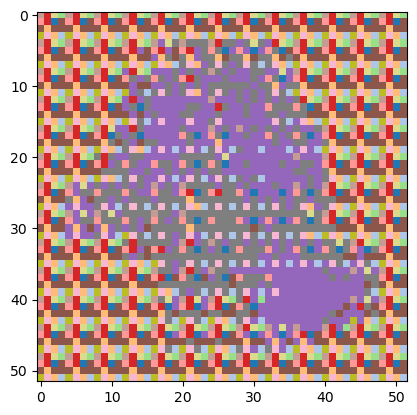

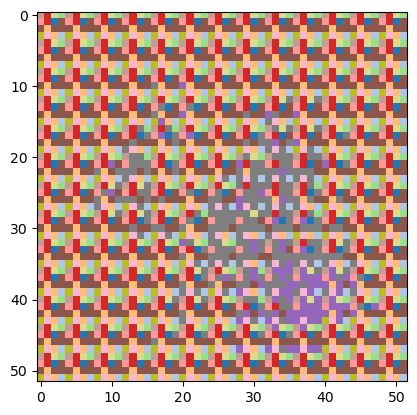

In [48]:
cmap = sns.color_palette('tab20')
for i, labeled in enumerate(stacked_labeled):
    plt.imshow(display_labeled_as_rgb(labeled, cmap=cmap))
    plt.show()

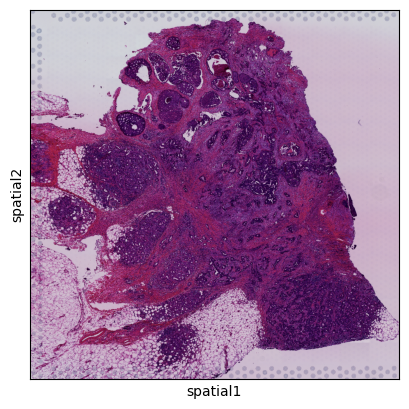

In [339]:
sc.pl.spatial(slide_to_adata['s0'])

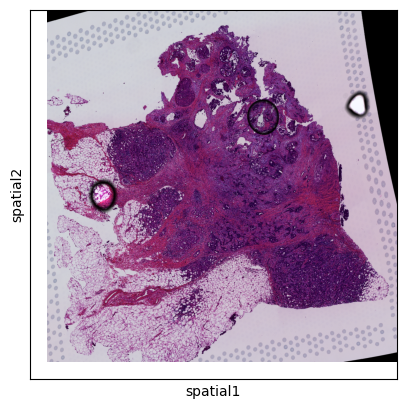

In [338]:
sc.pl.spatial(slide_to_adata['s3'])

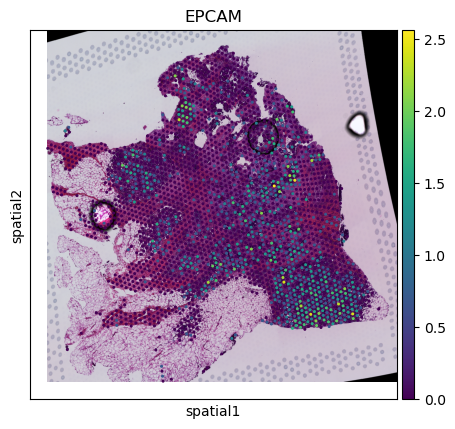

In [340]:
sc.pl.spatial(slide_to_adata['s3'], color='EPCAM')